# Data loading exploration

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.6 MB/s eta 0:00:00


Importing libs.

In [32]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts



Data loading

In [23]:


data = pd.read_csv('MarketPricePrediction.csv')

data.head()


,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


Data Exploring

In [24]:
data .describe()

,year,quantity,priceMin,priceMax,priceMod
count,10227.000000,1.022700e+04,10227.000000,10227.000000,10227.000000
mean,2009.022294,7.660488e+04,646.944363,1212.760731,984.284345
std,4.372841,1.244087e+05,673.121850,979.658874,818.471498
min,1996.000000,2.000000e+01,16.000000,145.000000,80.000000
25%,2006.000000,8.898000e+03,209.000000,557.000000,448.000000
50%,2009.000000,2.746000e+04,440.000000,923.000000,747.000000
75%,2013.000000,8.835650e+04,828.000000,1527.000000,1248.000000
max,2016.000000,1.639032e+06,6000.000000,8192.000000,6400.000000


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10227 entries, 0 to 10226
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   market    10227 non-null  object
 1   month     10227 non-null  object
 2   year      10227 non-null  int64 
 3   quantity  10227 non-null  int64 
 4   priceMin  10227 non-null  int64 
 5   priceMax  10227 non-null  int64 
 6   priceMod  10227 non-null  int64 
 7   state     10227 non-null  object
 8   city      10227 non-null  object
 9   date      10227 non-null  object
dtypes: int64(5), object(5)
memory usage: 799.1+ KB


# Data Preprocessing

In [26]:
data.isnull().sum()

market      0
month       0
year        0
quantity    0
priceMin    0
priceMax    0
priceMod    0
state       0
city        0
date        0
dtype: int64

In [27]:
data.duplicated().sum()

0

In [28]:

label_encoder = LabelEncoder()

data['market'] = label_encoder.fit_transform(data['market'])
data['month'] = label_encoder.fit_transform(data['month'])
data['state'] = label_encoder.fit_transform(data['state'])
data['city'] = label_encoder.fit_transform(data['city'])

data.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,0,4,2005,2350,404,493,446,16,0,January-2005
1,0,4,2006,900,487,638,563,16,0,January-2006
2,0,4,2010,790,1283,1592,1460,16,0,January-2010
3,0,4,2011,245,3067,3750,3433,16,0,January-2011
4,0,4,2012,1035,523,686,605,16,0,January-2012


In [29]:
data['date'] = pd.to_datetime(data['date'], format='%B-%Y')
data.set_index('date', inplace=True)
data.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city
date,,,,,,,,,
2005-01-01,0,4,2005,2350,404,493,446,16,0
2006-01-01,0,4,2006,900,487,638,563,16,0
2010-01-01,0,4,2010,790,1283,1592,1460,16,0
2011-01-01,0,4,2011,245,3067,3750,3433,16,0
2012-01-01,0,4,2012,1035,523,686,605,16,0


# Data plots

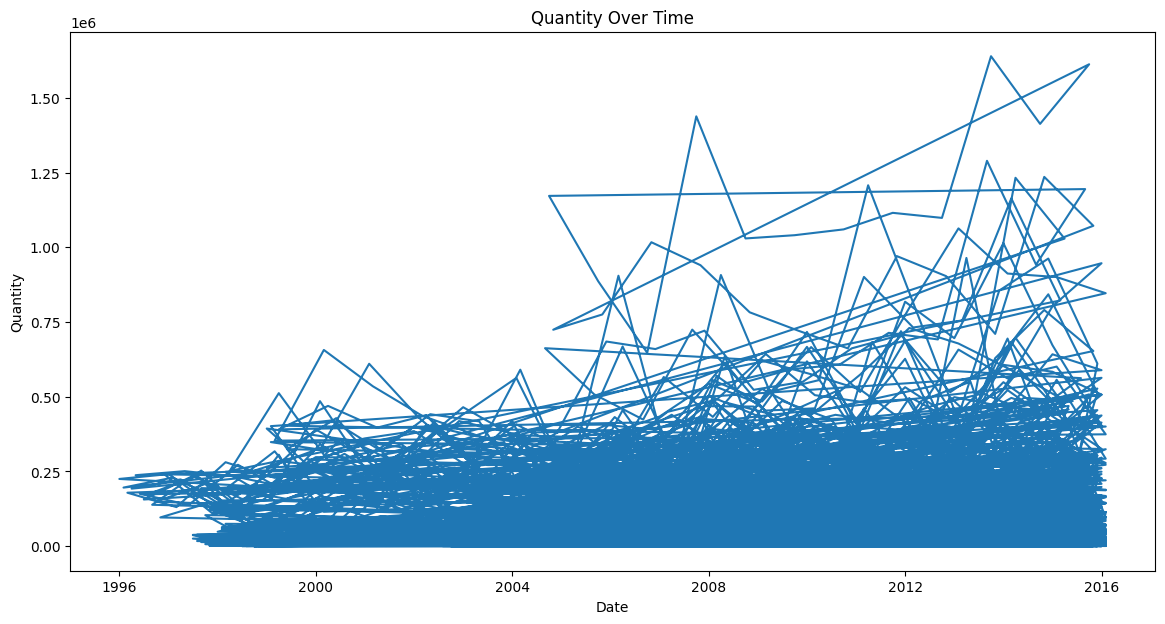

In [10]:
# Plot quantity over time
plt.figure(figsize=(14, 7))
plt.plot(data['quantity'])
plt.title('Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()




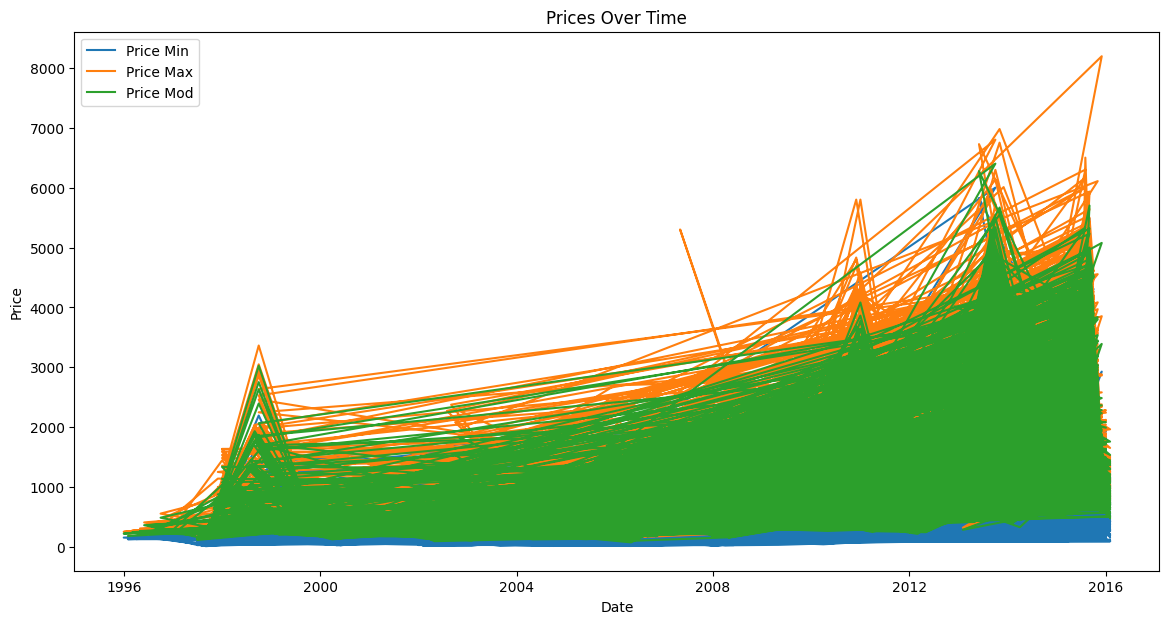

In [11]:
# Plot priceMin, priceMax, and priceMod over time
plt.figure(figsize=(14, 7))
plt.plot(data['priceMin'], label='Price Min')
plt.plot(data['priceMax'], label='Price Max')
plt.plot(data['priceMod'], label='Price Mod')
plt.title('Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

The decomposition of the quantity time series

Original Series: The original data.

Trend: The long-term trend in the data.

Seasonality: The repeating seasonal pattern in the data.

Residuals: The remaining noise after removing the trend and seasonality.

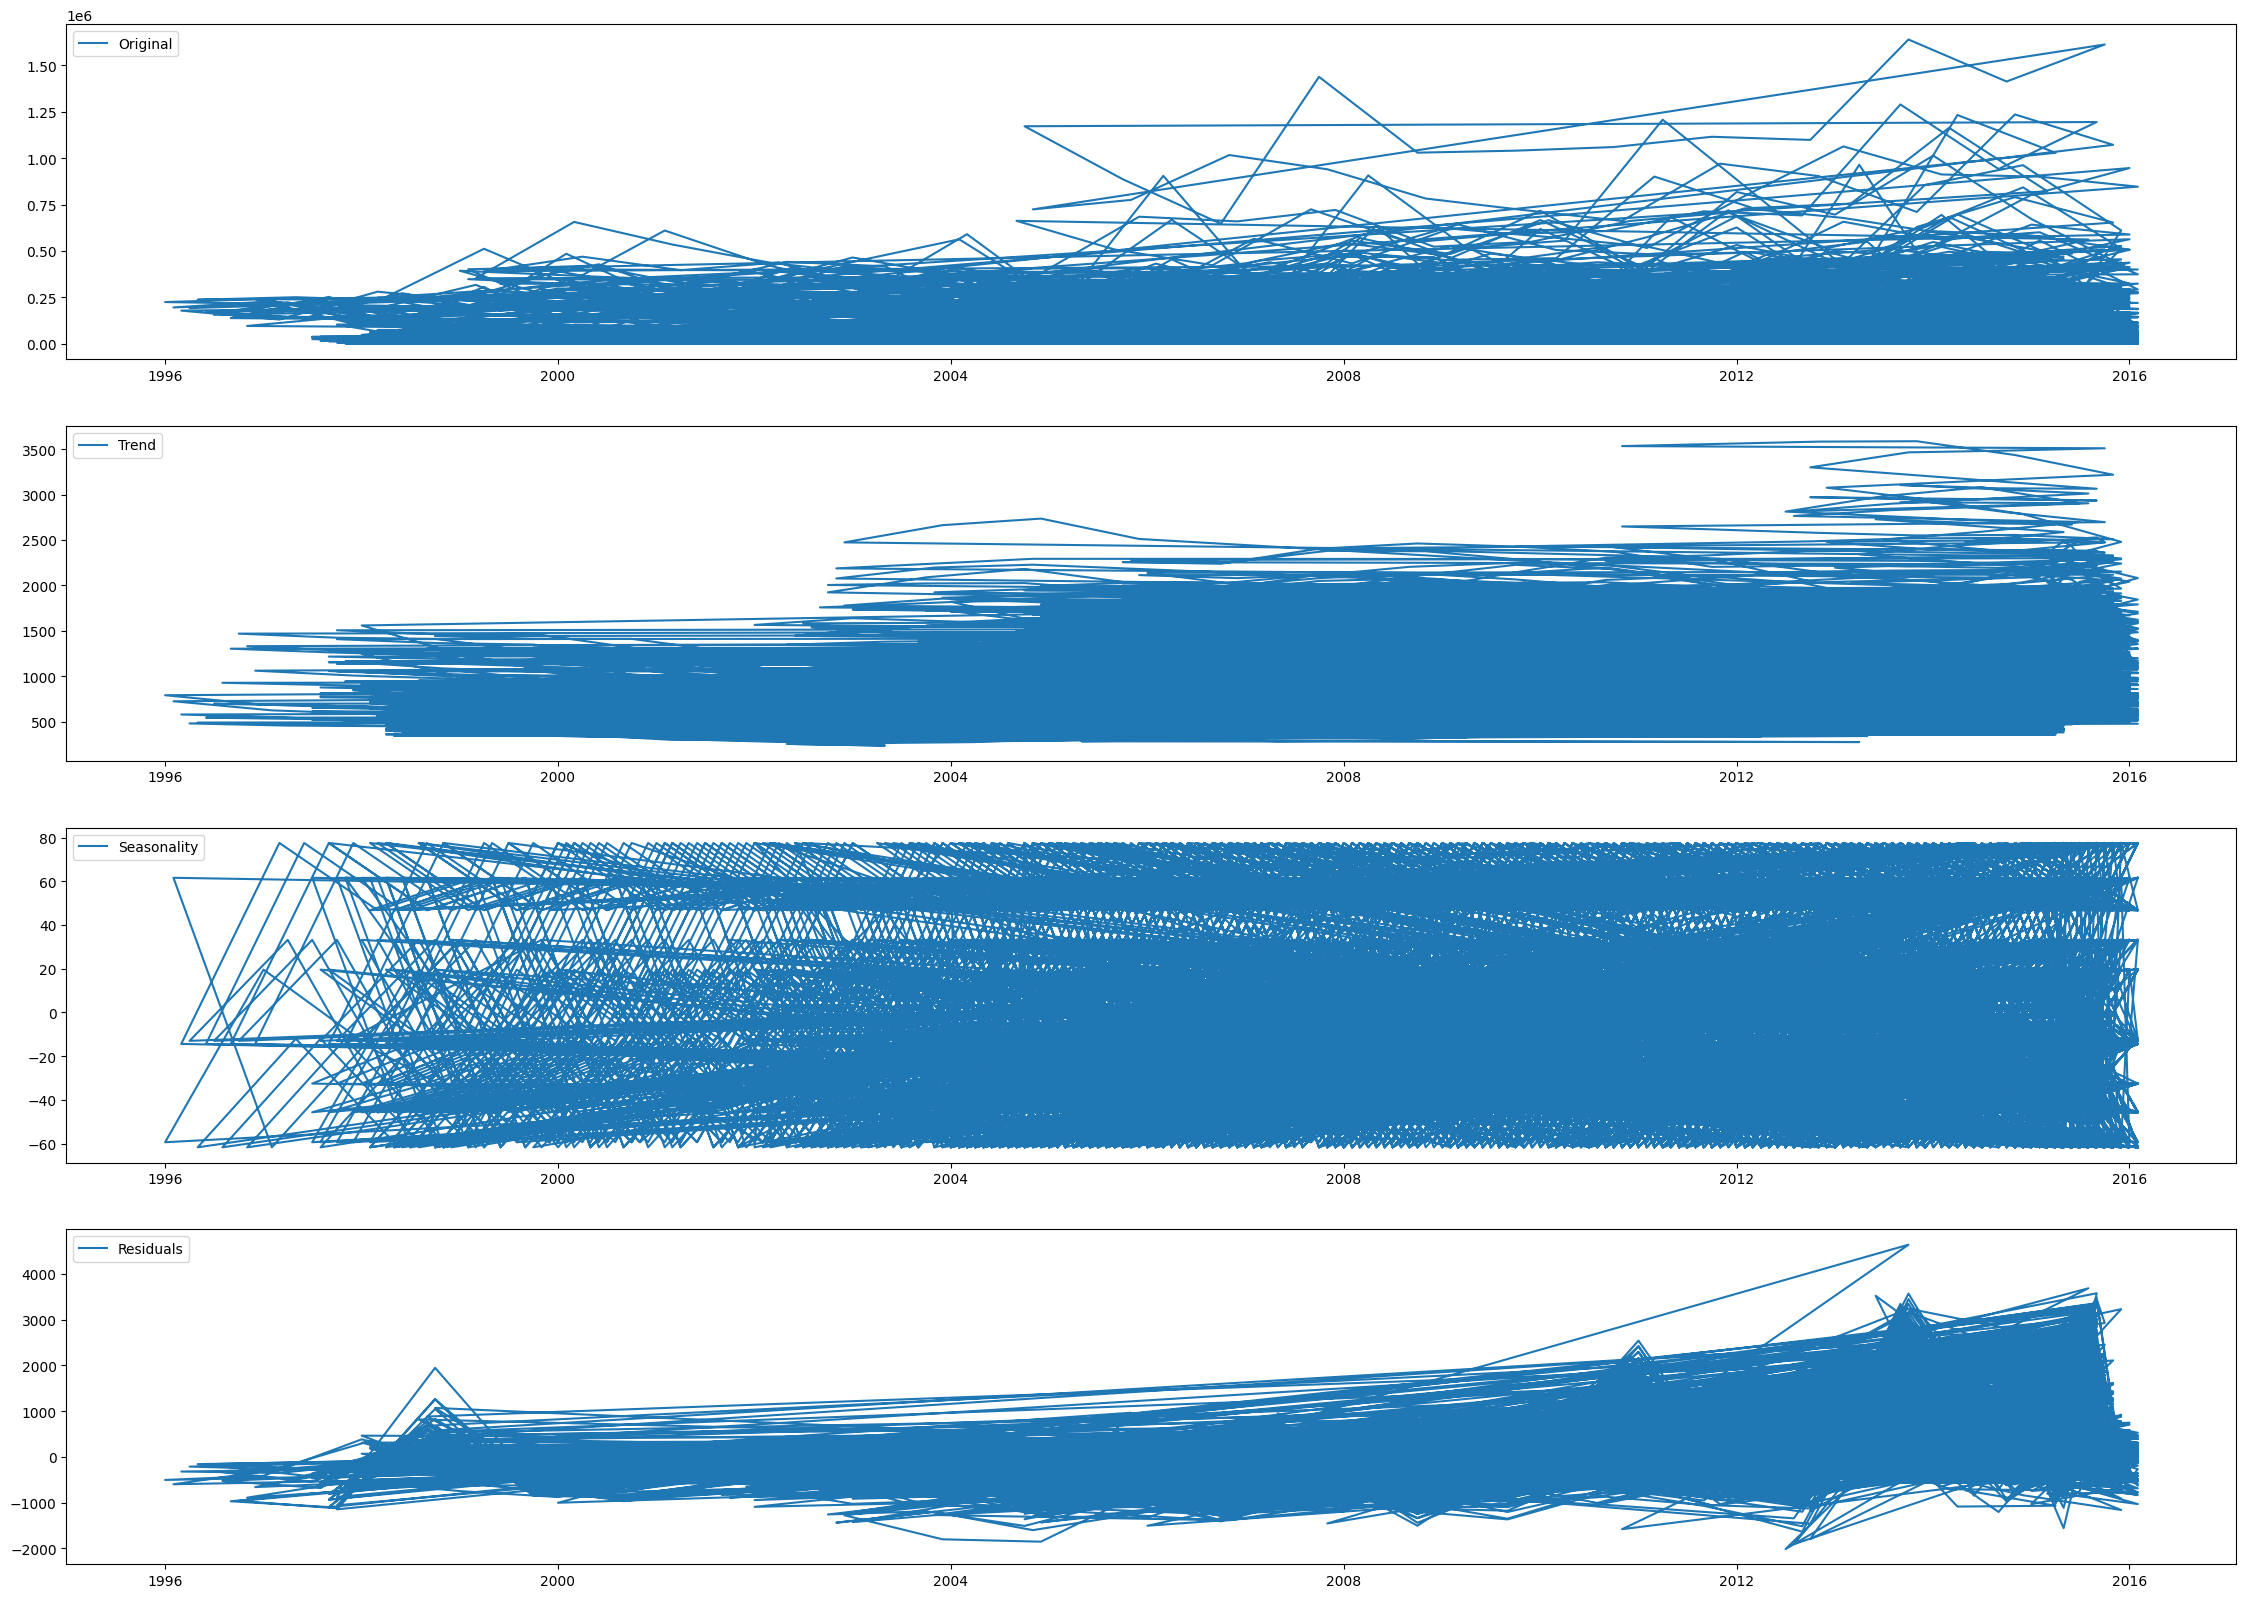

In [39]:
decomposition = seasonal_decompose(data['priceMod'], model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(28, 20))
plt.subplot(411)
plt.plot(data['quantity'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.show()

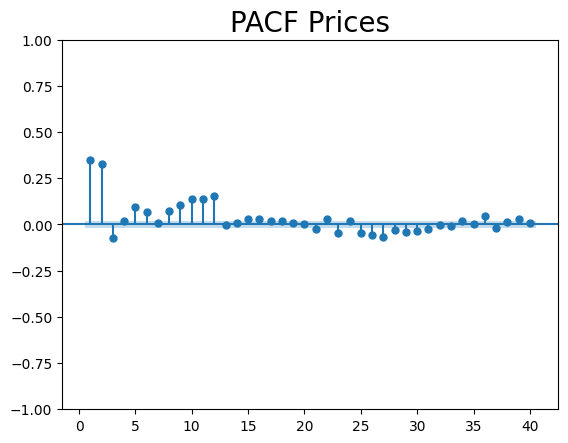

In [36]:
sgt.plot_pacf(data.priceMod, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF Prices", size = 20)
plt.show()

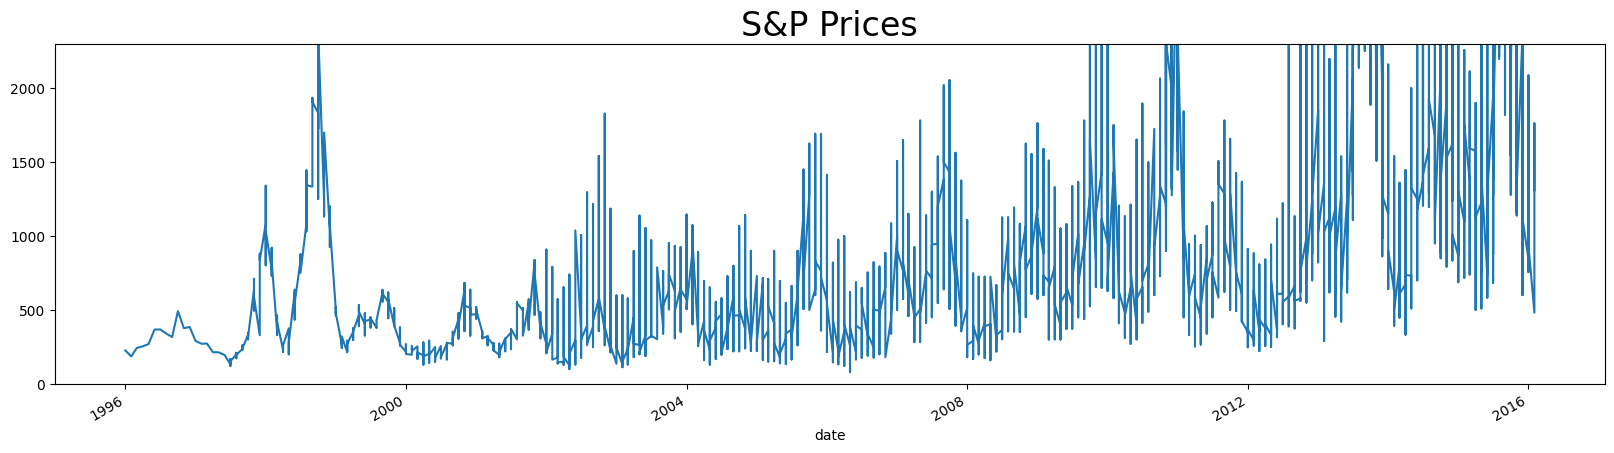

In [37]:
data.priceMod.plot(figsize=(20,5))
plt.title("S&P Prices", size = 24)
plt.ylim(0,2300)
plt.show()

Decomposition

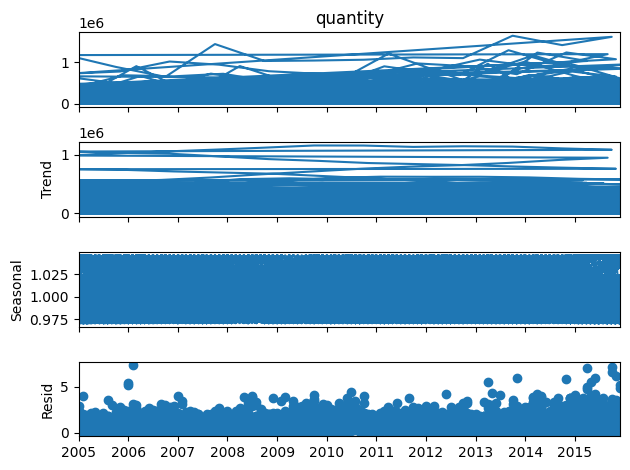

In [13]:

result = seasonal_decompose(data['quantity'], model='multiplicative', period=12)
result.plot()
plt.show()



# Feature Engineering


In [14]:
# Create lagged variables for quantity and prices
data['quantity_lag1'] = data['quantity'].shift(1)
data['priceMin_lag1'] = data['priceMin'].shift(1)
data['priceMax_lag1'] = data['priceMax'].shift(1)
data['priceMod_lag1'] = data['priceMod'].shift(1)

# Create rolling statistics (e.g., rolling mean and standard deviation)
data['quantity_roll_mean'] = data['quantity'].rolling(window=3).mean()
data['priceMin_roll_mean'] = data['priceMin'].rolling(window=3).mean()
data['priceMax_roll_mean'] = data['priceMax'].rolling(window=3).mean()
data['priceMod_roll_mean'] = data['priceMod'].rolling(window=3).mean()

data['quantity_roll_std'] = data['quantity'].rolling(window=3).std()
data['priceMin_roll_std'] = data['priceMin'].rolling(window=3).std()
data['priceMax_roll_std'] = data['priceMax'].rolling(window=3).std()
data['priceMod_roll_std'] = data['priceMod'].rolling(window=3).std()

# Drop rows with NaN values created by rolling statistics and lagged variables
data.dropna(inplace=True)

# Display the first few rows of the dataset with new features
data.head()


,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,quantity_lag1,...,priceMax_lag1,priceMod_lag1,quantity_roll_mean,priceMin_roll_mean,priceMax_roll_mean,priceMod_roll_mean,quantity_roll_std,priceMin_roll_std,priceMax_roll_std,priceMod_roll_std
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0,4,2010,790,1283,1592,1460,16,0,900.0,...,638.0,563.0,1346.666667,724.666667,907.666667,823.000000,870.651097,485.308493,597.068114,554.751296
2011-01-01,0,4,2011,245,3067,3750,3433,16,0,790.0,...,1592.0,1460.0,645.000000,1612.333333,1993.333333,1818.666667,350.749198,1321.153032,1594.345425,1468.232384
2012-01-01,0,4,2012,1035,523,686,605,16,0,245.0,...,3750.0,3433.0,690.000000,1624.333333,2009.333333,1832.666667,404.382245,1305.896372,1574.055060,1450.364207
2013-01-01,0,4,2013,675,1327,1900,1605,16,0,1035.0,...,686.0,605.0,651.666667,1639.000000,2112.000000,1881.000000,395.516540,1300.381482,1542.962086,1434.059971
2014-01-01,0,4,2014,440,1025,1481,1256,16,0,675.0,...,1900.0,1605.0,716.666667,958.333333,1355.666667,1155.333333,299.680385,406.124776,616.628197,507.543430


In [15]:
# Define the target variable and features
target = 'quantity'
features = ['quantity_lag1', 'priceMin_lag1', 'priceMax_lag1', 'priceMod_lag1',
            'quantity_roll_mean', 'priceMin_roll_mean', 'priceMax_roll_mean', 'priceMod_roll_mean',
            'quantity_roll_std', 'priceMin_roll_std', 'priceMax_roll_std', 'priceMod_roll_std']

In [16]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]


# Prophet model




In [17]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
from prophet import Prophet

In [18]:
# Prepare data for Prophet
prophet_data = data.reset_index()[['date', 'quantity']]
prophet_data.rename(columns={'date': 'ds', 'quantity': 'y'}, inplace=True)

# Split data into training and test sets
train_size = int(len(prophet_data) * 0.8)
train_prophet = prophet_data.iloc[:train_size]
test_prophet = prophet_data.iloc[train_size:]

# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_prophet)

# Make predictions
future = model.make_future_dataframe(periods=len(test_prophet), freq='M')
forecast = model.predict(future)

# Extract the forecasted values
test_prophet['yhat'] = forecast['yhat'].iloc[-len(test_prophet):].values

# Calculate evaluation metrics
mae = mean_absolute_error(test_prophet['y'], test_prophet['yhat'])
mse = mean_squared_error(test_prophet['y'], test_prophet['yhat'])
rmse = np.sqrt(mse)

# Display evaluation metrics
mae, mse, rmse


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3akglsdz/4n9_p1jq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3akglsdz/yze366xr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5303', 'data', 'file=/tmp/tmp3akglsdz/4n9_p1jq.json', 'init=/tmp/tmp3akglsdz/yze366xr.json', 'output', 'file=/tmp/tmp3akglsdz/prophet_model_x6jooqd/prophet_model-20240530140213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:02:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:02:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-18-b8b35cecf66b>:19: Setti

(307348.67167350795, 142492775095.92065, 377482.1520230071)

# GRID Search

In [19]:
# Drop rows with NaN values created by rolling statistics and lagged variables
data.dropna(inplace=True)

# Function to evaluate models using cross-validation
def evaluate_model(model, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()

# ARIMA model
arima_model = ARIMA(train[target], order=(5,1,0))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(steps=len(test))
arima_rmse = np.sqrt(mean_squared_error(test[target], arima_forecast))
arima_mae = mean_absolute_error(test[target], arima_forecast)
arima_mse = mean_squared_error(test[target], arima_forecast)

# XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(train[features], train[target])
xgb_forecast = xgb_model.predict(test[features])
xgb_rmse = np.sqrt(mean_squared_error(test[target], xgb_forecast))
xgb_mae = mean_absolute_error(test[target], xgb_forecast)
xgb_mse = mean_squared_error(test[target], xgb_forecast)

# Grid search for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
grid_search.fit(train[features], train[target])
best_xgb_model = grid_search.best_estimator_
best_xgb_forecast = best_xgb_model.predict(test[features])
best_xgb_rmse = np.sqrt(mean_squared_error(test[target], best_xgb_forecast))
best_xgb_mae = mean_absolute_error(test[target], best_xgb_forecast)
best_xgb_mse = mean_squared_error(test[target], best_xgb_forecast)

# Display evaluation metrics for ARIMA
print(f'ARIMA RMSE: {arima_rmse}')
print(f'ARIMA MAE: {arima_mae}')
print(f'ARIMA MSE: {arima_mse}')

# Display evaluation metrics for XGBoost
print(f'XGBoost RMSE: {xgb_rmse}')
print(f'XGBoost MAE: {xgb_mae}')
print(f'XGBoost MSE: {xgb_mse}')

# Display evaluation metrics for the best XGBoost model from grid search
print(f'Best XGBoost RMSE: {best_xgb_rmse}')
print(f'Best XGBoost MAE: {best_xgb_mae}')
print(f'Best XGBoost MSE: {best_xgb_mse}')
print(f'Best XGBoost Parameters: {grid_search.best_params_}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

ARIMA RMSE: 85188.233605619
ARIMA MAE: 44609.91377743327
ARIMA MSE: 7257035144.845514
XGBoost RMSE: 39688.36604666066
XGBoost MAE: 16159.666780521235
XGBoost MSE: 1575166399.4537268
Best XGBoost RMSE: 34628.62355455464
Best XGBoost MAE: 15182.89347180504
Best XGBoost MSE: 1199141569.2830563
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
